<a href="https://colab.research.google.com/github/therobinkay/firstmover/blob/main/First_mover_advantage_unused.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cd "drive/My Drive"

In [ ]:
# import all necessary packages

import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import math

from collections import defaultdict
from itertools import combinations as comb

import networkx as nx
import random

In [ ]:
# read necessary data files

data = pd.read_csv("drive/My Drive/codes/data.csv")
dp = pd.read_csv("drive/My Drive/codes/doipacs.csv")
cen = pd.read_csv('drive/My Drive/codes/cen.csv')
# cdata = pd.read_csv('drive/My Drive/codes/cdata.csv')
cb = pd.read_csv("drive/My Drive/codes/citationBara.csv")

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

# Select subfield (0-9)
N = 0

homn = pd.read_csv(f"drive/My Drive/codes/hom{N}.csv")

# q thresholds by subfield
qs = [0.002, 0.003, 0.003, 0.002, 0.0025, 0.006, 0.0018, 0.002, 0.0025, 0.006]

# print(len(homn))
# homn.head()

# UNUSED

## Female participation by year

In [ ]:
# Observe female participation by year, separated by primary

tdata = data.copy()
tdata.sort_values("id", inplace = True)
tdata.drop_duplicates(subset = ["id", "year"],
                         keep = "first", inplace = True)

fmtdata = tdata[tdata['gender'] == 'female'].groupby(['year'])['year'].count()

# Treating primary authors only
pdata = tdata[tdata['order'] == 1]

fmpdata = pdata[pdata['gender'] == 'female'].groupby(['year'])['year'].count()

In [ ]:
# Year vs. Proportion of Female Authors (Plot)

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

# Overall
(fmtdata/tdata.groupby(['year'])['year'].count()).plot(
    style='.-', color='black', lw=3)
# Primary
(fmpdata/pdata.groupby(['year'])['year'].count()).plot(
    style='.-', color='red', lw=3)

plt.legend(('overall', 'primary'), loc='upper left', fontsize=20)
plt.xticks(np.arange(1960, 2010, step=10), fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1960, xmax=2010)
plt.ylabel('Proportion of Female Authors', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0, ymax = 0.2)

plt.tight_layout()

## K-S Test for Productivity

In [ ]:
# Creating a DataFrame with productivity calculated
prod = data.groupby(['id', 'gender']).agg({'year': [min, max, 'count']})

prod['career_age'] = prod['year']['max'] - prod['year']['min']
prod['prod'] = prod['year']['count'] / (prod['career_age'])
prod = prod[prod['career_age'] != 0]

prod.sort_values([('year','count')], ascending=False).head()

# Separating the DataFrame by gender
prod_m = prod.xs('male', level='gender').sort_values(
    by=['prod'],ascending=False, ignore_index=True)
prod_fm = prod.xs('female', level='gender').sort_values(
    by=['prod'],ascending=False)

# Career Age by gender
camale = prod_m.groupby(['career_age'])['career_age'].count()
cafemale = prod_fm.groupby(['career_age'])['career_age'].count()

In [ ]:
#ks test (two-tailed)
from scipy.stats import ks_2samp
print(ks_2samp(prod_m['prod'], prod_fm['prod']))

#ks test: male > female
print(ks_2samp(prod_m['prod'], prod_fm['prod'], alternative='greater'))

#ks test: male < female
print(ks_2samp(prod_m['prod'], prod_fm['prod'], alternative='less'))

In [ ]:
# finding where the biggest difference occurs

def ks_2samp_x(data1, data2, alternative="two-sided"):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]

    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    cddiffs = cdf1 - cdf2
    minS = np.argmin(cddiffs)   # ks_2samp uses np.min or np.max respectively 
    maxS = np.argmax(cddiffs)   # now we get instead the index in data_all
    alt2Dvalue = {'less': minS, 'greater': maxS, 'two-sided': max(minS, maxS)}
    d_arg = alt2Dvalue[alternative]
    return data_all[d_arg]

print(ks_2samp_x(prod_m['prod'], prod_fm['prod']))
print(ks_2samp_x(prod_m['prod'], prod_fm['prod'], alternative="greater"))
print(ks_2samp_x(prod_m['prod'], prod_fm['prod'], alternative="less"))

## Self-citation proportion comparison

In [ ]:
# create a DataFrame with self-citing authors by gender

# all sample (population)
pop = cdata.copy().groupby(['citing_year'])['citing_year'].count()

# male authors
mpop = cdata.copy().loc[cdata['citing_gender'] == 'male'].groupby(
    ['citing_year'])['citing_year'].count()
# female authors
fpop = cdata.copy().loc[cdata['citing_gender'] == 'female'].groupby(
    ['citing_year'])['citing_year'].count()

# self citing authors
selfcit = cdata.copy().loc[cdata['citing_id'] == cdata['cited_id']].groupby(
    ['citing_year'])['citing_year'].count()

# male and self citing authors
m_sc = cdata.copy().loc[(cdata['citing_id'] == cdata['cited_id']) &
                   (cdata['citing_gender'] == 'male')].groupby(
                       ['citing_year'])['citing_year'].count()
# female and self citing authors
f_sc = cdata.copy().loc[(cdata['citing_id'] == cdata['cited_id']) & 
                     (cdata['citing_gender'] == 'female')].groupby(
                         ['citing_year'])['citing_year'].count()

# missing values to 0
pop[np.isnan(pop)] = 0
mpop[np.isnan(mpop)] = 0
fpop[np.isnan(fpop)] = 0
selfcit[np.isnan(selfcit)] = 0
m_sc[np.isnan(m_sc)] = 0
f_sc[np.isnan(f_sc)] = 0

In [ ]:
# create a self-citation ratio plot by year
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

(m_sc/mpop).plot(style='.-', color='#67a9cf', lw=3)
(f_sc/fpop).plot(style='.-',color='#ef8a62', lw=3)

# /plt.title('Self-citation Ratio by Year')
plt.legend(('male', 'female'), loc='upper right', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1950)
plt.xlim(xmax=2010)
plt.ylabel('Proportion of Self-citation', fontsize=20)
plt.ylim(ymin=0, ymax=0.15)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

## Missing Links

In [ ]:
# evaluate similar pairs by different p*
# evaluate the citation relationship within pairs

homn_qval = np.array(homn['qval'])

plist = np.unique(homn_qval)
klist = []
mlist = []

for pstar in plist:
    result = homn_qval < pstar
    sim = homn[result]
    mlist.append(len(sim))
    klist.append(sum(sim["k"]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


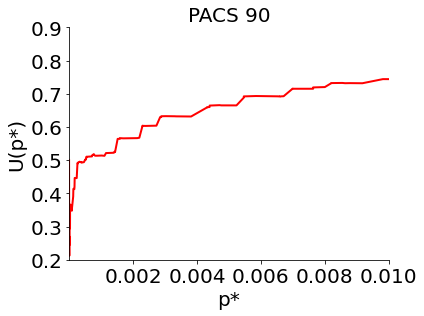

In [ ]:
# create a P(p*) plot

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

y_low = 0.2
y_high = 0.9

plt.figure(1)
plt.plot(plist, 1-np.array(klist)/np.array(mlist), color ='red', lw=2)

plt.title(f'PACS {N}0', fontsize = 20)
plt.xlabel("p*", fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(0.0000001,0.01)
plt.ylabel("U(p*)", fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=y_low, ymax=y_high)

plt.tight_layout()